In [1]:
import matplotlib.pyplot as plt
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy.integrate import quad
from import_file import import_file
from ambit_stochastics.trawl import trawl
from ambit_stochastics.helpers.loss_functions import compute_CRPS_loss
import statsmodels as sm

In [2]:
from pathlib import Path
modified_bfgs_script = import_file(os.path.join(Path(os.getcwd()).parent.parent,'modified_bfgs_script')) #why need this?????
#modified_minimize_bfgs = modified_minimize_bfgs.modified_minimize_bfgs
#modified_minimize = import_file(os.path.join(Path(os.getcwd()).parent,'modified_minimize'))

#from loss_functions import compute_deterministic_losses ,KL_a_b, KL_k_theta, compute_dm_test_p_value, compute_w_distance_from_dict_at_lag

loss_functions = import_file(os.path.join(Path(os.getcwd()).parent,'loss_functions'))
compute_deterministic_losses = loss_functions.compute_deterministic_losses
KL_a_b                              = loss_functions.KL_a_b
KL_k_theta                          = loss_functions.KL_k_theta
compute_dm_test_p_value             = loss_functions.compute_dm_test_p_value
compute_w_distance_from_dict_at_lag = loss_functions.compute_w_distance_from_dict_at_lag



2023-08-28 20:09:05.259787: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-28 20:09:05.364474: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-28 20:09:05.366835: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Helper functions

In [3]:
def process_d_gmm(d_gmm_, k_theta_bounds_, env_bounds_):
    d_filter_out = dict()
    
    for key,value in d_gmm_.items():
                
        upper_bound = np.concatenate([[i[1] for i in k_theta_bounds_], [i[1] for i in env_bounds_]])
        lower_bound = np.concatenate([[i[0] for i in k_theta_bounds_], [i[0] for i in env_bounds_]])
        
        interm = np.concatenate([value['levy_seed_params'], value['envelope_params']],axis=1)
        
        indicator = np.logical_or(interm <= lower_bound, interm >= upper_bound)
        d_filter_out[key] = indicator.copy().any(axis=1)            
        #return True if there is an issue
        
        #d_result[key] = d_gmm_[key].copy() #keep k theta 
        #d_result[key]['levy_seed_params'][:,1] = 1 / d_gmm_[key]['levy_seed_params'][:,1].copy()
    
    return d_filter_out
        

def process_d_cl(d_cl_all_, k_theta_bounds_, env_bounds_):
    d_result = dict()
    d_filter_out = dict()
    
    for key,value in d_cl_all_.items():
        
        
        interm = np.exp(np.array([i.x for i in value])).copy()
        interm[:,1]  = 1/ interm[:,1] #transform to k theta; d_cl_all_ comes with alpha bea 
        
        d_result[key] =  {'envelope_params':interm[:,2:].copy(), 'levy_seed_params':interm[:,:2].copy()}
        
        upper_bound = np.concatenate([[i[1] for i in k_theta_bounds_], [i[1] for i in env_bounds_]])
        lower_bound = np.concatenate([[i[0] for i in k_theta_bounds_], [i[0] for i in env_bounds_]])
        #print(upper_bound,lower_bound)

        
        indicator = np.logical_or(interm <=lower_bound , interm >= upper_bound)
        d_filter_out[key] = indicator.copy().any(axis=1)
        #return True if there is an issue
    
    return d_result, d_filter_out

def combine_dicts(d_index_1_, d_index_2_):
    assert set(d_index_1_.keys()) == set(d_index_2_.keys()) 
    d_common_index = dict()
    
    for key in d_index_1_.keys():
        #print('is ',d_index_1_[key],d_index_2_[key])
        d_common_index[key] = np.logical_or(d_index_1_[key] , d_index_2_[key])
        
    return d_common_index
        

def filter_results(d_unfiltered_, d_common_index_):
    d_filtered = dict()
    
    for key,value in d_unfiltered_.items():
        #print(type(key[0]))
        #print(value)
        d_filtered[key] = {'envelope_params': value['envelope_params'][~d_common_index_[key]],
                           'levy_seed_params':value['levy_seed_params'][~d_common_index_[key]]}
    
    return d_filtered      

In [4]:
def inference_metrics_helper(envelope_params,distributional_params,envelope,TRUE_ENVELOPE_PARAMS,beta_or_theta, 
                             TRUE_GAMMA_PARAMS,k):
    """uses the k theta parameterization"""
    #for multiple simulation, only to be used for gmm
    assert len(envelope_params) == len(distributional_params)
     
    #rMSE, MAE, MedAE for distributional params
    distr_error = np.abs(distributional_params - np.array(TRUE_GAMMA_PARAMS)) #make sure this works and takes teh difference
    env_error   = np.abs(envelope_params - np.array(TRUE_ENVELOPE_PARAMS))
    
    distributional_loss_1 = [np.sqrt(np.mean(distr_error[:,0]**2)),np.mean(distr_error[:,0]),np.median(distr_error[:,0])]
    distributional_loss_2 = [np.sqrt(np.mean(distr_error[:,1]**2)),np.mean(distr_error[:,1]),np.median(distr_error[:,1])]
    
    
    if beta_or_theta == 'theta':
        KL_loss = [KL_k_theta(TRUE_GAMMA_PARAMS[0],TRUE_GAMMA_PARAMS[1], j_[0], j_[1]) for j_ in distributional_params]
        
    elif beta_or_theta == 'beta':
        KL_loss = [KL_a_b(TRUE_GAMMA_PARAMS[0],TRUE_GAMMA_PARAMS[1], j_[0], j_[1]) for j_ in distributional_params]

    KL_loss = [np.mean(KL_loss),np.median(KL_loss)]
    
    
    individual_envelope_losses = []
    for i in range(envelope_params.shape[1]):
        
        indv_env_loss_to_add       = [np.sqrt(np.mean(env_error[:,i])), np.mean(env_error[:,i]), np.median(env_error[:,i])]
        individual_envelope_losses = individual_envelope_losses + indv_env_loss_to_add
    
    
    envelope_combined_loss = []
    for i in range(len(envelope_params)):
        func_sq_er  = lambda s : (corr_np(s,envelope,envelope_params[i]) - corr_np(s,envelope,TRUE_ENVELOPE_PARAMS))**2 / (k*s**2+1)
        func_abs_er = lambda s : abs(corr_np(s,envelope,envelope_params[i]) - corr_np(s,envelope,TRUE_ENVELOPE_PARAMS)) /(k*s**2+1)
        
        int_sq_er = quad(func_sq_er,0,np.inf,limit = 1000,maxp1=1000, limlst=1000,epsabs=1.49e-04, epsrel=1.49e-04)[0]
        int_abs_er= quad(func_abs_er,0,np.inf,limit = 1000,maxp1=1000, limlst=1000,epsabs=1.49e-04, epsrel=1.49e-04)[0]
        envelope_combined_loss.append([int_sq_er,int_abs_er])
    
    #'rMSE','MAE','MedAE' for envelope
    envelope_combined_loss  = np.array(envelope_combined_loss)
    envelope_combined_loss  = [np.sqrt(np.mean(envelope_combined_loss[:,0])), np.mean(envelope_combined_loss[:,1]), 
                               np.median(envelope_combined_loss[:,1])]
    #envelope_error = np.abs(envelope_params - np.array(TRUE_ENVELOPE_PARAMS))
    #envelope_loss = [np.sqrt(np.mean(envelope_error**2)),np.mean(envelope_error),np.median(envelope_error)]
    
    #print([distributional_loss_1,distributional_loss_2,KL_loss,envelope_loss])
    #print(np.concatenate([distributional_loss_1,distributional_loss_2,KL_loss,envelope_loss]).shape)
    return np.concatenate([distributional_loss_1,distributional_loss_2,KL_loss,individual_envelope_losses,envelope_combined_loss]) 

def compute_inference_metrics(dictionary_,envelope, envelope_params_names, TRUE_ENVELOPE_PARAMS,
                              beta_or_theta, TRUE_GAMMA_PARAMS, k):
    
    assert beta_or_theta in ('beta','theta')
    assert len(envelope_params_names) ==  len(TRUE_ENVELOPE_PARAMS)
    assert all(isinstance(item,str) for item in envelope_params_names)
    d_result = dict()
    for lags_to_use in lags_list:
        array = []
        for n_to_use in n_values:    
            
            if beta_or_theta == 'theta':
        
                array.append(inference_metrics_helper(dictionary_[(lags_to_use,n_to_use)]['envelope_params'],  
                                                      dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'],
                                                      envelope, TRUE_ENVELOPE_PARAMS,beta_or_theta,TRUE_GAMMA_PARAMS,k))  
            elif beta_or_theta == 'beta':
                
                levy_seed_beta_params_to_use = np.hstack(([dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'][:,[0]],
                            1/dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'][:,[1]]]))
                
                array.append(inference_metrics_helper(dictionary_[(lags_to_use,n_to_use)]['envelope_params'],
                                                      levy_seed_beta_params_to_use, envelope, TRUE_ENVELOPE_PARAMS,beta_or_theta,
                                                      (TRUE_GAMMA_PARAMS[0],1/TRUE_GAMMA_PARAMS[1]),k)) 
        
        if beta_or_theta == 'theta':
   
            greek_letters1 = [['α', 'α','α', 'θ', 'θ', 'θ', 'KL','KL'],
                             ["rMSE", "MAE", "MedAE",   "rMSE", "MAE", "MedAE",   'MKL','MedKL']]
        
        elif beta_or_theta == 'beta':
            greek_letters1 = [['α', 'α','α', 'β', 'β', 'β', 'KL','KL'],# 'acf','acf','acf'],
        ["rMSE", "MAE", "MedAE",   "rMSE", "MAE", "MedAE",   'MKL','MedKL']]
            
        env_1_duplicated_names = []
        for item in envelope_params_names:
            env_1_duplicated_names += [item,item,item]
        greek_letters2 = [env_1_duplicated_names +  ['acf']*3,
                         ["rMSE", "MAE", "MedAE"]*len(envelope_params_names) + ['rWMSE', 'MWAE', 'MedWAE']]
        
        #print(greek_letters1)
        #print('\n')
        #print(greek_letters2)

        greek_letters = [greek_letters1[0] + greek_letters2[0], greek_letters1[1] + greek_letters2[1]]

    
        greek_tuples = list(zip(*greek_letters))
        index = pd.MultiIndex.from_tuples(greek_tuples)#, names=["first", "second"])      
        #print('shape of 0th element is: ', array[0].shape)
        d_result[lags_to_use] =  pd.DataFrame(data = np.array(array) , index = n_values, columns = index)
    
    return d_result

def compute_mse_loss(h,tau,mu_L,var_L,envelope,true_envelope_params,lambda_,mu):
    
    """E[(X_{t+h* tau} - lambda_ * X_t - (1-lambda_) * mu)**2] =
    = var_L( 1 + lambda_**2 - 2 * lambda_ * rho(h))  + [(1-lambda_) * (mu_L - mu)]**2 
    
    these are numbers not vectors, corr_np doesn t work with vectors
    h is nr of steps ahead"""
    
    var_part  =  var_L * (1 + lambda_**2 - 2 * lambda_ * corr_np(h*tau,envelope,true_envelope_params))
    bias_part = (1-lambda_)**2 * (mu_L - mu) **2
    return var_part + bias_part


## Can't import jax libraries on windows, so will copy the function

In [5]:
#jax_aux_file_jitted_25_01_2023 = import_file(os.path.join(Path(os.getcwd()).parent,'jax_aux_file_jitted_25_01_2023.py'))

def corr_np(s,envelope,envelope_params):
    """return overlap area (i.e. correlation) Corr(X_t,X_{t+s}). these are equivalent because the area of the 
    ambit set is normalised to 1. s >0"""

    assert envelope in ['gamma','gamma_H']
    
      
    if envelope == 'gamma_H':
        H = envelope_params[0]
        area = (1+s/DELTA)**(-H)

    return area

## IMPORTANT: CHECK THESE

In [39]:
#############CHANGE THE FOLDER NAME ###########
folder_to_acces = os.path.join('results2')
###############################################


In [40]:
parameters___ = import_file(os.path.join(os.getcwd(),folder_to_acces,'parameters'))


levy_seed             = parameters___.levy_seed
tau                   =  float(parameters___.tau)
nr_trawl_simulations  = parameters___.nr_simulations
nr_trawls             = parameters___.nr_trawls
TRUE_GAMMA_PARAMS     =  parameters___.TRUE_GAMMA_PARAMS #keep it in k theta form
#TRUE_GAMMA_PARAMS     = (TRUE_GAMMA_PARAMS[0], 1/TRUE_GAMMA_PARAMS[1])
########################## WORK WITH alpha beta parameterization not k, theta for Gamma distribution ######################


envelope              = parameters___.envelope    #envelope  is one of  ['exponential','gamma','ig']
TRUE_ENVELOPE_PARAMS  = parameters___.TRUE_ENVELOPE_PARAMS[:1]
DELTA                 = parameters___.TRUE_ENVELOPE_PARAMS[1]
lags_list             = parameters___.lags_list
n_values              = parameters___.n_values
#np_random_seeds       = parameters___.np_random_seeds



#envelope_params_names = ('H',' 𝛿')
k_theta_bounds    = ((0.1, 100),(0.1,100))
alpha_beta_bounds = (k_theta_bounds[0], (1/k_theta_bounds[1][1], 1/k_theta_bounds[1][0]))
    
    
if envelope == 'gamma_H':
    envelope2 = 'gamma'
    envelope_params_names = ('H',)
    env_bounds = ((0.1,20),)

print('true k,theta gamma params are: ', TRUE_GAMMA_PARAMS) 
print('envelope_param_names ',envelope_params_names, ' are ', TRUE_ENVELOPE_PARAMS,'\n')

print('lags are: ', lags_list)
print('nr trawls in each simulation are: ',n_values,'\n')

print('the bounds for alpha and beta are: ',alpha_beta_bounds)
print('the envelope bounds are: ',env_bounds)


true k,theta gamma params are:  (3.0, 0.75)
envelope_param_names  ('H',)  are  (1.5,) 

lags are:  ((1, 3, 5, 10, 15, 20), (1, 3, 5, 10, 15), (1, 3, 5, 10))
nr trawls in each simulation are:  (2000, 1500, 1000, 750, 500) 

the bounds for alpha and beta are:  ((0.1, 100), (0.01, 10.0))
the envelope bounds are:  ((0.1, 20),)


In [41]:
with open(os.path.join(folder_to_acces,"cl_dictionary.pickle"), "rb") as input_file:
     d_cl_all = pickle.load(input_file)
     d_cl, d_index_cl = process_d_cl(d_cl_all,k_theta_bounds, env_bounds)

with open(os.path.join(folder_to_acces,"gmm_dictionary.pickle"), "rb") as input_file:
     d_gmm   = pickle.load(input_file)
     d_index_gmm   = process_d_gmm(d_gmm,k_theta_bounds, env_bounds)
    
d_index = combine_dicts(d_index_cl, d_index_gmm)
d_cl  = filter_results(d_unfiltered_ = d_cl, d_common_index_ = d_index)
d_gmm = filter_results(d_unfiltered_ = d_gmm, d_common_index_ = d_index)



print('number of bad simulations out of ',nr_trawl_simulations)
print('gmm: ',[np.sum(value) for value in d_index_gmm.values()])
print('cl: ',[np.sum(value) for value in d_index_cl.values()])
print('combined: ',[np.sum(value) for value in d_index.values()])

number of bad simulations out of  100
gmm:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cl:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
combined:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [42]:
all_values_ = np.load(os.path.join(os.getcwd(),folder_to_acces,'values.npy'))

def get_initial_value_for_1_param_trawl_function(tau_ ,values_,envelope,aux_param):
    
    emp_corr_at_lag_1 = np.array([sm.tsa.stattools.acf(i,nlags =1)[[1]] for i in all_values_])
    
    if envelope == 'exponential':
        assert aux_param == None
        return (-1/tau_) * np.log(emp_corr_at_lag_1)  
    
    elif envelope == 'gamma_H':
        assert isinstance(aux_param,tuple) and len(aux_param) == 1
        delta = aux_param[0]
        return - np.log(emp_corr_at_lag_1) / np.log(1+ tau_/DELTA)


#plt.hist(get_initial_value_for_1_param_trawl_function(tau_ = tau, values_ = all_values_, envelope = 'exponential',aux_param  = None));
#r_H = get_initial_value_for_1_param_trawl_function(tau_ = tau, values_ = all_values_, envelope = 'gamma_H',aux_param  = (0.75,))
#plt.hist(r_H);
#plt.axvline(TRUE_ENVELOPE_PARAMS[0],c='red')

In [43]:
#
#import scipy.stats
#print(scipy.stats.gamma.fit(all_values_[11][:500], floc = 0, method ='MLE' ))
#print(scipy.stats.gamma.fit(all_values_[11][:500], floc = 0, method ='MM' ))
#d_gmm[((1, 3, 5, 10), 500)]['levy_seed_params'][10:13]
#_ = plt.hist(all_values_.mean(axis=1))

In [44]:
list(d_gmm.keys())

[((1, 3, 5, 10, 15, 20), 2000),
 ((1, 3, 5, 10, 15), 2000),
 ((1, 3, 5, 10), 2000),
 ((1, 3, 5, 10, 15, 20), 1500),
 ((1, 3, 5, 10, 15), 1500),
 ((1, 3, 5, 10), 1500),
 ((1, 3, 5, 10, 15, 20), 1000),
 ((1, 3, 5, 10, 15), 1000),
 ((1, 3, 5, 10), 1000),
 ((1, 3, 5, 10, 15, 20), 750),
 ((1, 3, 5, 10, 15), 750),
 ((1, 3, 5, 10), 750),
 ((1, 3, 5, 10, 15, 20), 500),
 ((1, 3, 5, 10, 15), 500),
 ((1, 3, 5, 10), 500)]

assert envelope in ['exponential', 'gamma', 'ig']
#assert isinstance(envelope_params, tuple) and isinstance(jump_part_params, tuple)
np.random.seed(seed=np_random_seeds[0])

if envelope == 'exponential':

    assert len(envelope_params) == 1
    lambda_ = envelope_params[0]
    trawl_function = lambda x: lambda_ * np.exp(x * lambda_) * (x <= 0)

elif envelope == 'gamma':

    assert len(TRUE_ENVELOPE_PARAMS) == 2
    H, delta = TRUE_ENVELOPE_PARAMS
    trawl_function = lambda x: H / delta * (1 - x / delta) ** (-H - 1) * (x <= 0)

elif envelope == 'ig':

    assert len(envelope_params) == 2
    gamma, delta = envelope_params
    # total_area = gamma/delta change of varialbe ()**-0.5 = z
    trawl_function = lambda x: (delta / gamma) * (1 - 2 * x / gamma ** 2) ** (-0.5) * np.exp(
        delta * gamma * (1 - (1 - 2 * x / gamma ** 2) ** 0.5)) * (x <= 0)

decorrelation_time = -np.inf
gaussian_part_params = (0, 0)
jump_part_name = 'gamma'

trawl_slice = trawl(nr_trawls=nr_trawls, nr_simulations=nr_trawl_simulations, trawl_function=trawl_function, tau=tau,
                    decorrelation_time=decorrelation_time, gaussian_part_params=gaussian_part_params,
                    jump_part_name='gamma', jump_part_params=TRUE_GAMMA_PARAMS)

trawl_slice.simulate('slice', 'diagonals')

In [45]:
#d1____ = d_cl[((1, 3, 5,10),  1000)]
#d2____ = d_gmm[((1, 3, 5,10),  1000)]

#np_seed_list_1 = np.random.randint(low = 1, high = 100000,size=100)
#np_seed_list_2 = np.random.randint(low = 1, high = 100000,size=100)


#result1 = compute_w_distance_from_dict_at_lag(tau = tau,nr_simulations = 1000, max_nr_trawls = 10,
#                                    envelope = envelope, np_seed_list_1 = np_seed_list_1, np_seed_list_2 = np_seed_list_2, d = d1____, 
#                                    TRUE_GAMMA_PARAMS= TRUE_GAMMA_PARAMS,TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS)

In [46]:
#result2 = compute_w_distance_from_dict_at_lag(tau = tau,nr_simulations = 1000, max_nr_trawls = 10,
#                                    envelope = envelope, np_seed_list_1 = np_seed_list_1, np_seed_list_2 = np_seed_list_2,
#                                    d = d2____,       TRUE_GAMMA_PARAMS= TRUE_GAMMA_PARAMS,TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS)
#100 *(np.median(result1,axis=0) - np.median(result2,axis=0)) / np.median(result2,axis=0)
#100 * np.std(result1,axis=0) / np.mean(result1,axis=0), 100 * np.std(result2,axis=0)/ np.mean(result2,axis=0)

In [47]:
#array([-4.84371423, -4.60201371])
#array([-3.38044489, -3.20209775])


#np.save(file= 'slice_matrix.npy',arr = trawl_slice.slice_areas_matrix)
#trawl_slice.slice_areas_matrix[:,2][-5:]




#_____= np.exp(d_cl_all[((1, 3, 5, 10),  1000)][indeces[0]].x)
#print(_____[0] / _____[1])
#print(np.prod(d_gmm[((1, 3, 5, 10),  1000)]['levy_seed_params'][indeces[0]]))



#import seaborn as sns
#_ = sns.kdeplot(d_cl[((1, 3, 5, 10),  500)]['levy_seed_params'][:,0], c = 'blue')
#_ = sns.kdeplot(d_gmm[((1, 3, 5,10),  500)]['levy_seed_params'][:,0], c = 'orange')
#plt.axvline(TRUE_GAMMA_PARAMS[0])


#scipy.linalg.eig(d_cl_all[((1, 3, 5, 10),  1000)][indeces[3]].hess_inv)

#plt.hist(np.mean(all_values,axis=1))
#np.mean(all_values,axis=1)>5

In [48]:
folder_to_acces

'results2'

In [49]:
beta_or_theta = 'beta'
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS, k = 0.01)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS, k = 0.01)
#cl_result[lags_list[0]] 

#lags_list
#print(folder_to_acces)

if folder_to_acces == 'results1':
    lag_latex_table = (1,3,5,10,15,20,30,40)    
    
elif folder_to_acces == 'results2':
    lag_latex_table = (1,3,5,10,15)
    
elif folder_to_acces == 'results3':
    lag_latex_table =  (1,3,5,7) 
    

    
all_columns_list = cl_result[lag_latex_table].columns
columns_latex = [i for i in all_columns_list if i[0] != 'acf' ]
    
    
estimatio_error_table = (cl_result[lag_latex_table] / gmm_result[lag_latex_table])[columns_latex]
estimatio_error_table_for_latex = estimatio_error_table.style.format(decimal='.', thousands=',', precision=2)
print(estimatio_error_table_for_latex.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
 & \multicolumn{3}{r}{α} & \multicolumn{3}{r}{β} & \multicolumn{2}{r}{KL} & \multicolumn{3}{r}{H} \\
 & rMSE & MAE & MedAE & rMSE & MAE & MedAE & MKL & MedKL & rMSE & MAE & MedAE \\
2000 & 0.66 & 0.65 & 0.64 & 0.66 & 0.68 & 0.74 & 0.74 & 0.71 & 0.48 & 0.23 & 0.26 \\
1500 & 0.70 & 0.69 & 0.68 & 0.68 & 0.72 & 0.77 & 0.77 & 0.72 & 0.50 & 0.25 & 0.23 \\
1000 & 0.66 & 0.64 & 0.58 & 0.68 & 0.66 & 0.68 & 0.78 & 0.68 & 0.53 & 0.28 & 0.23 \\
750 & 0.59 & 0.64 & 0.81 & 0.67 & 0.65 & 0.60 & 0.64 & 0.74 & 0.52 & 0.27 & 0.25 \\
500 & 0.42 & 0.53 & 0.51 & 0.60 & 0.63 & 0.59 & 0.46 & 0.65 & 0.52 & 0.27 & 0.24 \\
\end{tabular}



In [50]:
lags_list


((1, 3, 5, 10, 15, 20), (1, 3, 5, 10, 15), (1, 3, 5, 10))

In [51]:
#beta_or_theta = 'beta'
#gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
#                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
#                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS, k = 0.0001)
#cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
#                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
#                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS, k = 0.0001)
#cl_result[lags_list[-1]]

In [52]:
beta_or_theta = 'beta' #!!!!!!!!!!!!!!!!!! check that this is displayed correctly
gmm_result= compute_inference_metrics(dictionary_ = d_gmm, envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS =  TRUE_ENVELOPE_PARAMS,  beta_or_theta =  beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.01)
cl_result = compute_inference_metrics(dictionary_ = d_cl,envelope = envelope, envelope_params_names = envelope_params_names,
                                      TRUE_ENVELOPE_PARAMS = TRUE_ENVELOPE_PARAMS, beta_or_theta = beta_or_theta,
                                      TRUE_GAMMA_PARAMS = TRUE_GAMMA_PARAMS,k=0.01)

#cl_result[(1,  3,  5,  10,  15)] / gmm_result[(1,  3,  5,  10,  15)]
#cl_result[1,3,5,10,15]/ gmm_result[(1,  3,  5,10,15)]
for lag_to_use in lags_list: 
    for loss_to_use in [['MAE','MKL'],['rMSE','MKL'],['MedAE','MedKL']]:
    #for loss_to_use in [['MAE','MKL'],['rMSE','MKL'],['MedAE','MedKL']]:

        
        entries = list(cl_result[lag_to_use].columns)
        entries = [i  for i in entries if i[1] in loss_to_use]
        
        data_to_plot = (cl_result[lag_to_use] / gmm_result[lag_to_use]).loc[:,entries]
        #print(entries)
        f =sns.lineplot(data =data_to_plot,dashes=False, markers = ['X','o','s','D']);
        f.axhline(1,c='black')
        f.set_xticks(n_values) # <--- set the ticks first

        
        plot_file_name = '' 
        for i in lag_to_use:
            plot_file_name += str(i) +'_'
        plot_file_name += loss_to_use[0] +'_marker_on.pdf'
        
        (f.get_figure()).savefig(os.path.join(folder_to_acces,plot_file_name),bbox_inches = 'tight', format = 'pdf')
        plt.close(f.get_figure())

In [38]:
folder_to_acces

'results1'

In [127]:
#np.max(d_cl[((1, 3, 5,10),  500)]['envelope_params'])
d_cl[((1, 3, 5,10,15),  1000)]

KeyError: ((1, 3, 5, 10, 15), 1000)

In [ ]:
ff, axax = plt.subplots(1,2,figsize=(17.5,5))
axax[0].hist(d_cl[((1, 3, 5, 10),  1000)]['levy_seed_params'][:,0],density=True);
axax[1].hist(d_cl[((1, 3, 5, 10),  1000)]['levy_seed_params'][:,1],density=True);

In [ ]:
ff, axax = plt.subplots(1,2,figsize=(17.5,5))
axax[0].hist(d_gmm[((1, 3, 5,  10),  1000)]['levy_seed_params'][:,0],density=True);
axax[1].hist(d_gmm[((1, 3, 5,  10),  1000)]['levy_seed_params'][:,1],density=True);

In [ ]:
print('cl versus gmm in %: hopefully results are negative')
round(100 * (cl_result[(1, 3, 5,10,15)] - gmm_result[(1, 3, 5,10,15)]) / gmm_result[(1, 3, 5,10,15)],2)
#print(corr_np(15,'gamma',TRUE_ENVELOPE_PARAMS))

In [ ]:
print('cl versus gmm in %: hopefully results are negative')
round(100 * (cl_result[(1, 3, 5,10,15)] - gmm_result[(1, 3, 5,10,15)]) / gmm_result[(1, 3, 5,10,15)],2)


In [ ]:
print('cl versus gmm in %: hopefully results are negative')
round(100 * (cl_result[(1, 3,5,10)] - gmm_result[(1, 3,5,10)]) / gmm_result[(1, 3,5,10)],1)


In [ ]:
print('cl at different lags in %: hopefully small changes')
round(100 * (cl_result[(1, 3,5,10,15)] - cl_result[(1, 3,5,10)]) / cl_result[(1, 3,5,10)],2)


In [87]:
def forecast_and_assess_cond_exp_loss(tau, dictionary_,steps_ahead, levy_seed, envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,folder_to_acces):
    
    
    all_values = np.load(os.path.join(os.getcwd(),folder_to_acces,'values.npy'))
    trawl_ = trawl(nr_simulations = nr_trawl_simulations, nr_trawls = nr_trawls, tau = tau)
    
    d_cond_exp_losses = {}
    d_cond_exp_dm_test= {} #DM NOT WORKING ATM
    
    #index_1 = [item for item in n_values for i in range(len(steps_ahead))]
    #index_2 = list(np.tile(steps_ahead,len(n_values))) 
    
    columns_hierarchical_index = pd.MultiIndex.from_product([n_values[::-1], ['MAE', 'MedAE','rMSE','MQLIKE']])

    
    for lags_to_use in lags_list:
        array = np.array([]).reshape([0,4])
        for n_to_use in n_values[::-1]: 
            
            
            zzzzzz = dict()
            zzzzzz_env                 = dictionary_[(lags_to_use,n_to_use)]['envelope_params'].copy()
            zzzzzz['envelope_params']  = np.hstack([zzzzzz_env, DELTA * np.ones(zzzzzz_env.shape)])
            zzzzzz['levy_seed_params'] = dictionary_[(lags_to_use,n_to_use)]['levy_seed_params'].copy()
            
            trawl_.infered_parameters = {'envelope': envelope2, 'levy_seed': levy_seed, 'params' :zzzzzz }
                                         #dictionary_[(lags_to_use,n_to_use)]}
            inferred_values_dict = trawl_.predict(input_values = all_values[:,n_to_use:], steps_ahead = steps_ahead, deterministic  = True)  
            
            if n_to_use == n_values[-1]:
                array = compute_deterministic_losses(all_values[:,n_to_use:],inferred_values_dict)

            else:
                array = np.concatenate([array,compute_deterministic_losses(all_values[:,n_to_use:],inferred_values_dict)],axis=1)

            d_cond_exp_dm_test[(lags_to_use,n_to_use)] = inferred_values_dict
            
        
        d_cond_exp_losses[lags_to_use] = pd.DataFrame(array,index = steps_ahead, columns = columns_hierarchical_index)
                                             #columns = ['MAE', 'MedAE','rMSE','MQLIKE'])
    return d_cond_exp_losses,d_cond_exp_dm_test

In [88]:
gmm_cond_exp_loss, gmm_dm = forecast_and_assess_cond_exp_loss(tau,d_gmm,(1,2,3,4,5,6,10),levy_seed, envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,folder_to_acces)
cl_cond_exp_loss, cl_dm = forecast_and_assess_cond_exp_loss(tau,d_cl,(1,2,3,4,5,6,10),levy_seed,envelope, TRUE_ENVELOPE_PARAMS,TRUE_GAMMA_PARAMS,folder_to_acces)


In [1]:
exclude_qlike_col_list = [i for i in cl_cond_exp_loss[lags_list[0]].columns if i[1] != 'MQLIKE']

lag_for_forecasting = (1,3,5,7)
forecasting_table = 100 * ((cl_cond_exp_loss[lag_for_forecasting] - gmm_cond_exp_loss[lag_for_forecasting]) /cl_cond_exp_loss[lag_for_forecasting])[exclude_qlike_col_list]
forecasting_table_for_latex = forecasting_table.style.format(decimal='.', thousands=',', precision=2)
forecasting_table_for_latex


NameError: name 'cl_cond_exp_loss' is not defined

In [59]:
#gmm_cond_exp_loss[lags_list[2]]# / gmm_cond_exp_loss[lags_list[2]]
(cl_cond_exp_loss[lags_list[0]]/gmm_cond_exp_loss[lags_list[0]]-1)*100

MAE     MedAE      rMSE    MQLIKE
2000 1  -0.949732 -2.815117 -0.207793 -0.511594
     2  -0.889917 -1.843681 -0.345516 -0.638920
     3  -0.764175 -1.393566 -0.420754 -0.691412
     4  -0.703628 -0.972545 -0.454444 -0.711491
     5  -0.675269 -1.412923 -0.501032 -0.730535
     6  -0.661571 -1.124974 -0.523436 -0.763175
     10 -0.461122 -0.395066 -0.492518 -0.652555
     15 -0.313098 -0.148807 -0.380573 -0.572482
     20 -0.249564 -0.007702 -0.283836 -0.484647
     25 -0.174647 -0.027791 -0.187629 -0.369102
     30 -0.107723  0.080420 -0.143127 -0.386400
1500 1  -1.227861 -3.514563 -0.282596 -0.501301
     2  -1.051980 -2.393635 -0.429240 -0.688000
     3  -0.925836 -1.897360 -0.507640 -0.769737
     4  -0.785046 -1.406777 -0.541081 -0.806236
     5  -0.706043 -1.357571 -0.554807 -0.856806
     6  -0.656758 -0.982213 -0.544512 -0.885070
     10 -0.408819 -0.529279 -0.464936 -0.784308
     15 -0.262347 -0.074487 -0.370587 -0.679845
     20 -0.237803 -0.082132 -0.314562 -0.633545
     25 -0.172244 -0.064067 -0.242431 -0.526884
     30 -0.093323  0.055760 -0.173577 -0.393671
1000 1  -1.280039 -3.947803 -0.301211 -0.472705
     2  -1.080216 -2.589287 -0.466787 -0.632181
     3  -0.955465 -2.138382 -0.561626 -0.707874
     4  -0.828157 -1.578601 -0.610016 -0.739206
     5  -0.742314 -1.222798 -0.623908 -0.766238
     6  -0.685698 -0.829779 -0.623857 -0.791316
     10 -0.446568 -0.308466 -0.558118 -0.772336
     15 -0.243895  0.094093 -0.430371 -0.617329
     20 -0.178526  0.020820 -0.355442 -0.547899
     25 -0.135430  0.282099 -0.297964 -0.493582
     30 -0.075443  0.263162 -0.233999 -0.412014
750  1  -1.739909 -5.207042 -0.444211 -0.884991
     2  -1.500172 -3.428005 -0.690295 -1.147909
     3  -1.350108 -2.777194 -0.820778 -1.243258
     4  -1.200722 -2.392047 -0.879522 -1.251537
     5  -1.091190 -1.815963 -0.887918 -1.264512
     6  -1.001990 -1.396127 -0.884209 -1.282866
     10 -0.679848 -0.563214 -0.780404 -1.217071
     15 -0.441372 -0.009122 -0.617784 -1.011323
     20 -0.313433  0.104388 -0.479861 -0.835899
     25 -0.213542  0.082881 -0.375708 -0.686775
     30 -0.149718 -0.020569 -0.296666 -0.576632
500  1  -2.592114 -7.576506 -0.645012 -1.554574
     2  -2.285845 -5.381564 -0.999109 -1.924140
     3  -2.081384 -4.250136 -1.189689 -2.074122
     4  -1.884206 -3.617336 -1.275032 -2.098587
     5  -1.760806 -3.179693 -1.302983 -2.097727
     6  -1.645695 -2.610809 -1.314698 -2.110215
     10 -1.214355 -1.438656 -1.176132 -1.908122
     15 -0.811606 -0.760568 -0.932892 -1.539263
     20 -0.600350 -0.563799 -0.763076 -1.272997
     25 -0.455600 -0.295611 -0.635664 -1.069306
     30 -0.375622 -0.121684 -0.532638 -0.919397

##### TRUE_GAMMA_PARAMS, TRUE_ENVELOPE_PARAMS,DELTA


In [60]:
result_3_problem_index = np.argmin(d_cl[((1,3,5,10),500)]['levy_seed_params'][:,0])
print(d_gmm[((1,3,5,10),500)]['levy_seed_params'][result_3_problem_index])
d_cl_all[((1,3,5,10),500)][result_3_problem_index]

[2.0311416  0.86016468]


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.0031391475660265
        x: [ 7.986e-01  2.425e-01  6.909e-01]
      nit: 6
      jac: [ 2.372e-05 -3.179e-05  3.389e-05]
 hess_inv: [[ 1.042e+00  9.558e-01 -3.554e-01]
            [ 9.558e-01  1.268e+00 -1.887e-01]
            [-3.554e-01 -1.887e-01  1.739e+00]]
     nfev: 53
     njev: 41

In [61]:
100 * (  cl_cond_exp_loss[lags_list[1]] -  gmm_cond_exp_loss[lags_list[1]] )  / gmm_cond_exp_loss[lags_list[1]] 
#cl_cond_exp_loss[(1,3,5)].loc[500]  / gmm_cond_exp_loss[(1,3,5)].loc[500]

MAE     MedAE      rMSE    MQLIKE
2000 1  -0.901556 -2.656550 -0.194491 -0.453518
     2  -0.841217 -1.834660 -0.321042 -0.562076
     3  -0.719024 -1.334295 -0.389335 -0.616851
     4  -0.659157 -0.945222 -0.418540 -0.639233
     5  -0.626354 -1.230362 -0.460967 -0.657866
     6  -0.617584 -1.062308 -0.483592 -0.695586
     10 -0.428371 -0.334764 -0.453704 -0.603240
     15 -0.285212 -0.179214 -0.349557 -0.536002
     20 -0.231483 -0.038154 -0.263103 -0.462362
     25 -0.159356 -0.035722 -0.171126 -0.350887
     30 -0.094683  0.046106 -0.131013 -0.369514
1500 1  -1.161387 -3.244755 -0.269027 -0.448610
     2  -0.990286 -2.270496 -0.407333 -0.618496
     3  -0.867672 -1.816704 -0.479651 -0.698789
     4  -0.730926 -1.345204 -0.509313 -0.734475
     5  -0.654089 -1.187501 -0.521260 -0.782783
     6  -0.610438 -0.885351 -0.511365 -0.813883
     10 -0.376866 -0.548411 -0.435154 -0.734072
     15 -0.243837  0.000051 -0.347743 -0.642412
     20 -0.226471 -0.032046 -0.297111 -0.604684
     25 -0.162257 -0.042897 -0.225432 -0.500504
     30 -0.081136  0.036919 -0.156923 -0.369926
1000 1  -1.236861 -3.816181 -0.296951 -0.465873
     2  -1.050121 -2.528342 -0.462551 -0.628926
     3  -0.931279 -2.018649 -0.556885 -0.711134
     4  -0.811927 -1.441037 -0.605688 -0.743841
     5  -0.726755 -1.175011 -0.619901 -0.766831
     6  -0.674335 -0.760567 -0.619704 -0.789334
     10 -0.445605 -0.348629 -0.558412 -0.774218
     15 -0.249900  0.122786 -0.432032 -0.619800
     20 -0.187824 -0.004473 -0.358764 -0.550679
     25 -0.138331  0.351657 -0.298592 -0.492547
     30 -0.072199  0.284774 -0.231425 -0.405873
750  1  -1.661612 -4.970550 -0.429394 -0.857853
     2  -1.435893 -3.278096 -0.668924 -1.118218
     3  -1.289644 -2.685247 -0.794322 -1.217697
     4  -1.149012 -2.259034 -0.850257 -1.222923
     5  -1.042746 -1.679696 -0.857799 -1.230453
     6  -0.956631 -1.316130 -0.853916 -1.244723
     10 -0.651276 -0.526448 -0.755611 -1.179585
     15 -0.424401  0.033787 -0.600616 -0.977680
     20 -0.305890  0.124655 -0.469734 -0.807392
     25 -0.204899  0.092229 -0.367989 -0.663920
     30 -0.139839  0.003189 -0.288509 -0.553946
500  1  -2.450559 -7.169389 -0.608656 -1.436195
     2  -2.156604 -5.078633 -0.945438 -1.794879
     3  -1.959636 -4.072407 -1.126379 -1.950578
     4  -1.775298 -3.411731 -1.208050 -1.978589
     5  -1.654643 -3.010579 -1.234830 -1.980630
     6  -1.547023 -2.418555 -1.247026 -1.996614
     10 -1.142339 -1.318763 -1.118664 -1.817966
     15 -0.767951 -0.684470 -0.894467 -1.479971
     20 -0.576274 -0.500803 -0.739863 -1.237743
     25 -0.438897 -0.273249 -0.617896 -1.044387
     30 -0.363641 -0.078889 -0.518142 -0.897940

In [47]:
overlap_area_gmm = np.exp(-d_gmm[((1, 3,5,10),  1500)]['envelope_params'])
overlap_area_cl = np.exp(-d_cl[((1, 3,5,10),  1500)]['envelope_params'])

overlap_area_gmm_error       = np.abs(overlap_area_gmm - corr_np(tau,envelope,TRUE_ENVELOPE_PARAMS))
overlap_area_cl_error        = np.abs(overlap_area_cl - corr_np(tau,envelope,TRUE_ENVELOPE_PARAMS))


In [48]:
print('results for gmm and then cl')
print('MA is',round(np.mean(np.abs(overlap_area_gmm_error)),4), round(np.mean(np.abs(overlap_area_cl_error)),4))
print('MedAE is', round(np.median(np.abs(overlap_area_gmm_error)),4), round(np.median(np.abs(overlap_area_cl_error)),4))
print('rMSE is', round(np.mean(np.abs(overlap_area_gmm_error)**2)**0.5,4),round(np.mean(np.abs(overlap_area_cl_error)**2)**0.5,4))

results for gmm and then cl
MA is 0.6677 0.6458
MedAE is 0.6843 0.6467
rMSE is 0.6727 0.6463


In [49]:
TRUE_ENVELOPE_PARAMS

(1.5,)

##### 

In [32]:
mean_errors_gmm = np.abs(d_gmm[((1, 3, 5,7,10),  1000)]['levy_seed_params'][:,0] / d_gmm[((1, 3, 5,7,10),  1000)]['levy_seed_params'][:,1] - TRUE_GAMMA_PARAMS[0] / TRUE_GAMMA_PARAMS[1])
mean_errors_cl = np.abs(d_cl[((1, 3, 5,7,10),  1000)]['levy_seed_params'][:,0] / d_cl[((1, 3, 5,7,10),  1000)]['levy_seed_params'][:,1] -  TRUE_GAMMA_PARAMS[0] / TRUE_GAMMA_PARAMS[1])

KeyError: ((1, 3, 5, 7, 10), 1000)

In [33]:
np.mean(mean_errors_gmm), np.mean(mean_errors_cl)

NameError: name 'mean_errors_gmm' is not defined

In [74]:
np.median(mean_errors_gmm), np.median(mean_errors_cl)

NameError: name 'mean_errors_gmm' is not defined

In [75]:
np.mean(mean_errors_gmm**2)**0.5, np.mean(mean_errors_cl**2)**0.5

NameError: name 'mean_errors_gmm' is not defined

In [76]:
TRUE_GAMMA_PARAMS[0] / TRUE_GAMMA_PARAMS[1]

4.0

In [77]:
envelope_params_names

('H',)

In [34]:
import scipy
e_values = [np.sum(scipy.linalg.eig(i.hess_inv)[0]**2)**0.5 for i in d_cl_all[((1, 3, 5, 10),  1000)]]
indeces = (np.argsort(e_values))[::-1]
#e_values[indeces[0]]
#e_values[indeces[3]]
d_gmm[((1, 3, 5, 10),  500)]['levy_seed_params'][indeces[0]]
#print(d_gmm[((1, 3, 5, 10),  250)]['levy_seed_params'][15])
#print(d_cl[((1, 3, 5, 10),  250)]['levy_seed_params'][15])

all_values = np.load(os.path.join(os.getcwd(),folder_to_acces,'values_par2.npy'))
#plt.hist((all_values**2).mean(axis=1))
#np.argmin((all_values**2).mean(axis=1))
#scipy.stats.gamma.fit(all_values[15][:270], floc = 0, method ='MM' )

#scipy.stats.gamma.fit(all_values[indeces[0]][:7500][::10], floc = 0, method ='MLE' )

d_gmm[((1, 3, 5, 10,15),  1000)]['levy_seed_params']
argnum = np.argmax([np.sum(i.jac**2) for i in d_cl_all[((1, 3, 5, 10,15),  1000)]])
d_cl_all[((1, 3, 5, 10),  500)][argnum]
set([i.status for i in d_cl_all[((1, 3, 5, 10),  1000)] ])
#d_cl[((1, 3, 5, 10,15),  500)]['envelope_params'][arg_num] = d_gmm[((1, 3, 5, 10,15),  500)]['envelope_params'][arg_num]
#d_cl[((1, 3, 5, 10,15),  500)]['levy_seed_params'][arg_num] = d_gmm[((1, 3, 5, 10,15),  500)]['levy_seed_params'][arg_num]

status_3 = np.argmax([i.status==3 for i in d_cl_all[((1, 3, 5, 10),  1000)] ]  )
#d_gmm[((1, 3, 5, 10,15),  1000)]['levy_seed_params'][status_3]
#d_cl[((1, 3, 5, 10,15),  1000)]['levy_seed_params'][status_3]

plt.hist(d_gmm[((1, 3, 5, 10,15),  1500)]['levy_seed_params'][:,0])


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/ambit_stochastics_container_folder/inference/gamma_levy_seed/inference_results/gamma_H/results2/values_par2.npy'

In [162]:
cl_result[(1,  3,  5,7)] / gmm_result[(1,  3,  5,7)]

α                             θ                            KL  \
          rMSE       MAE     MedAE      rMSE       MAE     MedAE       MKL   
2000  0.637731  0.612843  0.591257  0.667122  0.700936  0.699382  0.724012   
1500  0.641047  0.632727  0.687307  0.640693  0.694269  0.853921  0.716871   
1000  0.615795  0.610651  0.616623  0.609770  0.694576  0.878414  0.680189   
750   0.622466  0.636193  0.602361  0.610715  0.698158  0.735674  0.677057   
500   0.649208  0.654352  0.586514  0.745789  0.746279  0.750276  0.753996   

                       H                           acf                      
         MedKL      rMSE       MAE     MedAE     rWMSE      MWAE    MedWAE  
2000  0.651983  0.571487  0.326597  0.434823  0.251950  0.279337  0.418158  
1500  0.651782  0.570879  0.325903  0.451660  0.226427  0.256778  0.458946  
1000  0.696086  0.576792  0.332688  0.445645  0.238138  0.250307  0.467909  
750   0.559224  0.558766  0.312219  0.380911  0.233499  0.244212  0.384851  
500   0.708158  0.563826  0.317900  0.353518  0.356878  0.362539  0.429201

In [161]:
cl_result[(1,  3,  5)] / gmm_result[(1,  3,  5)]

α                             θ                            KL  \
          rMSE       MAE     MedAE      rMSE       MAE     MedAE       MKL   
2000  0.638100  0.613288  0.592897  0.667599  0.701511  0.701281  0.724109   
1500  0.641056  0.632873  0.691015  0.640876  0.694926  0.855449  0.716942   
1000  0.615899  0.610692  0.609561  0.609912  0.694787  0.876628  0.680321   
750   0.622677  0.636396  0.602312  0.610795  0.698628  0.736214  0.677078   
500   0.649308  0.654558  0.584398  0.746944  0.746315  0.749769  0.754279   

                       H                           acf                      
         MedKL      rMSE       MAE     MedAE     rWMSE      MWAE    MedWAE  
2000  0.651668  0.588071  0.345828  0.469151  0.270697  0.304688  0.487774  
1500  0.649799  0.589536  0.347552  0.487085  0.245469  0.283854  0.494268  
1000  0.698470  0.593370  0.352088  0.495187  0.259406  0.277129  0.469282  
750   0.559340  0.577249  0.333216  0.395252  0.249202  0.265489  0.426410  
500   0.708202  0.580033  0.336438  0.369589  0.374131  0.382919  0.422851

In [1]:
n_values

NameError: name 'n_values' is not defined

In [1]:
import seaborn as sns
data_to_plot1 = (cl_result[(1,  3,  5,10,15,20)] / gmm_result[(1,  3,  5,10,15,20)]).loc[:,[(  'α',    'MedAE'),(  'θ',   'MedAE'),
                                                                                        ('KL','MedKL'),(  'H',    'MedAE')
                                                                                 ]]

f =sns.lineplot(data =data_to_plot1,dashes=False, markers = ['X','X','X','X']);
f.axhline(1,c='black')
f.set_xticks(n_values)
#f.set(ylim=(0.2,1.1))
plt.tight_layout()
f.figure.savefig(f'H_{TRUE_GAMMA_PARAMS[0]}.pdf')


NameError: name 'cl_result' is not defined

In [83]:
import seaborn as sns
data_to_plot1 = (cl_result[(1,  3,  5,10,15)] / gmm_result[(1,  3,  5,10,15)]).loc[:,[(  'α',    'MAE'),(  'θ',   'MAE'),
                                                                        (  'H',    'MAE'),(' δ','MAE')
                                                                                 ]]
g =sns.lineplot(data =data_to_plot1,dashes=False, markers = ['X','X','X','X']);
g.axhline(1,c='black')


KeyError: "[(' δ', 'MAE')] not in index"

In [72]:
data_to_plot1

,α,θ,H,δ
,MedAE,MedAE,MedAE,MedAE
1500,0.900463,0.833257,0.951801,1.000066
1000,0.867193,0.980806,0.866694,0.974381
500,0.777826,0.945962,0.992326,0.988468
250,0.818730,0.966435,1.034235,1.150968


In [76]:
d_index[((1, 3, 5, 10, 15),  1000)].sum()

0

(array([0.70789865, 1.26831841, 0.56041976, 0.17697466, 0.08848733,
        0.05899155, 0.02949578, 0.        , 0.02949578, 0.02949578]),
 array([0.18013669, 0.51916828, 0.85819986, 1.19723145, 1.53626303,
        1.87529461, 2.2143262 , 2.55335778, 2.89238937, 3.23142095,
        3.57045254]),
 <BarContainer object of 10 artists>)

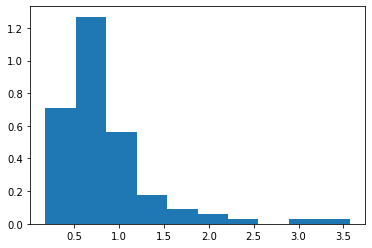

In [71]:
plt.hist(d_gmm[((1, 3, 5, 10, 15),  1500)]['envelope_params'][:,0],density=True)